## Imports

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy      as np
import tensorflow as tf

from tf_agents                       import specs
from tf_agents.networks              import actor_distribution_network
from quantum_control_rl_server       import PPO
from quantum_control_rl_server       import remote_env_tools as rmt
from quantum_control_rl_server.h5log import h5log

In [2]:
root_dir = os.getcwd() 
host_ip  = '127.0.0.1' # ip address of RL server, here it's hosted locally

In [3]:
num_epochs       = 100 # total number of training epochs
train_batch_size = 50 # number of batches to send for training epoch

do_evaluation    = True # flag for implementing eval epochs or not
eval_interval    = 20 # number of training epochs between eval epochs
eval_batch_size  = 1 # number of batches to send for eval epoch

learn_residuals  = True
save_tf_style    = False

In [4]:
# Define the pulse params
# Here I will choose num_pts number of points and use interpolation to build a pulse from those points.
# As initial seed, I will use a constant pulse.


num_pts     = 6   # Number of points on the pulse
amp         = 0.1 # Pulse amplitude
amp_scale   = 0.5

init_I_arr  = list( np.ones(6) * amp )
init_Q_arr  = list( np.zeros(6) )

scale_I_arr = list( np.ones(num_pts, dtype=float)*amp_scale )
scale_Q_arr = list( np.ones(num_pts, dtype=float)*amp_scale )



In [5]:

# Params for action wrapper
action_script = {
  'I_arr' : [init_I_arr], # shape=[1,1]
  'Q_arr' : [init_Q_arr], # shape=[1,1]
  }

# specify shapes of actions to be consistent with the objects in action_script
action_spec = {
  'I_arr'     : specs.TensorSpec(shape=[num_pts], dtype=tf.float32),
  'Q_arr'     : specs.TensorSpec(shape=[num_pts], dtype=tf.float32)
  }

# characteristic scale of sigmoid functions used in the neural network, 
# and for automatic differentiation of the reward
# optimal point should ideally be within +/- action_scale of the initial vals
action_scale = {
  'I_arr'    : scale_I_arr,
  'Q_arr'    : scale_Q_arr,
  }

# flags indicating whether actions will be learned or scripted
to_learn = {
  'I_arr'     : True,
  'Q_arr'     : True,
  }

rl_params = {'num_epochs'       : num_epochs,
             'train_batch_size' : train_batch_size,
             'do_evaluation'    : do_evaluation,
             'eval_interval'    : eval_interval,
             'eval_batch_size'  : eval_batch_size,
             'learn_residuals'  : learn_residuals,
             'action_script'    : action_script,
             #'action_spec' : action_spec, # doesn't play nice with h5 files
             'action_scale'     : action_scale,
             'to_learn'         : to_learn,
             'save_tf_style'    : save_tf_style}

log = h5log(root_dir, rl_params)

\\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\h5log.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.filename)


In [6]:

############################################################
# Below code shouldn't require modification for normal use #
############################################################

# Create drivers for data collection
from quantum_control_rl_server import dynamic_episode_driver_sim_env

server_socket = rmt.Server()
(host, port) = (host_ip, 5555) 
server_socket.bind((host, port))
server_socket.connect_client()

# Params for environment
env_kwargs = eval_env_kwargs = {
  'T' : 1}

# Params for reward function
reward_kwargs = {
    'reward_mode'   : 'remote',
    'server_socket' : server_socket,
    'epoch_type'    : 'training'}

reward_kwargs_eval = {
    'reward_mode'   : 'remote',
    'server_socket' : server_socket,
    'epoch_type'    : 'evaluation'}

collect_driver = dynamic_episode_driver_sim_env.DynamicEpisodeDriverSimEnv(
    env_kwargs, reward_kwargs, train_batch_size, action_script, action_scale,
    action_spec, to_learn, learn_residuals, remote=True)

eval_driver = dynamic_episode_driver_sim_env.DynamicEpisodeDriverSimEnv(
    eval_env_kwargs, reward_kwargs_eval, eval_batch_size, action_script, action_scale,
    action_spec, to_learn, learn_residuals, remote=True)

PPO.train_eval(
    root_dir    = root_dir,
    random_seed = 0,
    num_epochs  = num_epochs,
    # Params for train
    normalize_observations    = True,
    normalize_rewards         = False,
    discount_factor           = 1.0,
    lr                        = 2.5e-3,
    lr_schedule               = None,
    num_policy_updates        = 20,
    initial_adaptive_kl_beta  = 0.0,
    kl_cutoff_factor          = 0,
    importance_ratio_clipping = 0.1,
    value_pred_loss_coef      = 0.005,
    gradient_clipping         = 1.0,
    entropy_regularization    = 0,
    log_prob_clipping         = 0.0,
    # Params for log, eval, save
    eval_interval       = eval_interval,
    save_interval       = 2,
    checkpoint_interval = None,
    summary_interval    = 2,
    do_evaluation       = do_evaluation,
    # Params for data collection
    train_batch_size       = train_batch_size,
    eval_batch_size        = eval_batch_size,
    collect_driver         = collect_driver,
    eval_driver            = eval_driver,
    replay_buffer_capacity = 15000,
    # Policy and value networks
    ActorNet                      = actor_distribution_network.ActorDistributionNetwork,
    zero_means_kernel_initializer = False,
    init_action_stddev = 0.08,
    actor_fc_layers    = (50,20),
    value_fc_layers    = (),
    use_rnn            = False,
    actor_lstm_size    = (12,),
    value_lstm_size    = (12,),
    h5datalog          = log,
    save_tf_style      = save_tf_style
    )


05/17/2023 06:48:35 Connection with: ('127.0.0.1', 52620)
05/17/2023 06:48:35 Only tf.keras.optimizers.Optimiers are well supported, got a non-TF2 optimizer: <tensorflow.python.training.adam.AdamOptimizer object at 0x000001F1B4D67400>
\\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\h5log.py:70: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.filename)


-------------------
Epoch 0
  Policy steps: 0
  Experience time: 0.00 mins
  Policy train time: 0.00 mins
  Average return: -0.90709
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


05/17/2023 06:48:37 From \\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\PPO.py:230: ReplayBuffer.gather_all (from tf_agents.replay_buffers.replay_buffer) is deprecated and will be removed in a future version.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


-------------------
Epoch 20
  Policy steps: 400
  Experience time: 0.39 mins
  Policy train time: 0.30 mins
  Average return: -0.42581
-------------------
Epoch 40
  Policy steps: 800
  Experience time: 0.75 mins
  Policy train time: 0.32 mins
  Average return: 0.88172
-------------------
Epoch 60
  Policy steps: 1200
  Experience time: 1.10 mins
  Policy train time: 0.35 mins
  Average return: -0.45754
-------------------
Epoch 80
  Policy steps: 1600
  Experience time: 1.46 mins
  Policy train time: 0.37 mins
  Average return: 0.10604
-------------------
Epoch 100
  Policy steps: 2000
  Experience time: 1.83 mins
  Policy train time: 0.40 mins
  Average return: 0.67207


In [8]:
import h5py
import numpy             as np
import matplotlib.pyplot as plt


# Get the results of training 
root_dir = os.getcwd()
filename = root_dir+r'\20230517.h5'
key      = '3'
with h5py.File(filename,'r') as f :
    print(f.keys())
    rl_params        = {key:item for key,item in f[key]['rl_params'].attrs.items()}
    training_actions = {key:item[()] for key,item in f[key]['training']['actions'].items()}
    epochs           = np.arange(rl_params['num_epochs'])
    training_rewards = f[key]['training']['rewards'][()]

<KeysViewHDF5 ['0', '1', '2', '3']>


In [10]:
# Calculate infidelity and its std deviation
infidelity       = (1-training_rewards)/2.0
mean_infidelity  = np.mean(infidelity,axis=1)
stdev_infidelity = np.std(infidelity,axis=1)
min_infidelity   = np.amin(infidelity,axis=1)
max_infidelity   = np.amax(infidelity,axis=1)

# Calculate mean and std. deviation of learned params
mean_I  = np.mean(training_actions['I_arr'],axis=1)
stdev_I = np.std(training_actions['I_arr'],axis=1)
min_I   = np.amin(training_actions['I_arr'],axis=1)
max_I   = np.amax(training_actions['I_arr'],axis=1)

mean_Q  = np.mean(training_actions['Q_arr'],axis=1)
stdev_Q = np.std(training_actions['Q_arr'],axis=1)
min_Q   = np.amin(training_actions['Q_arr'],axis=1)
max_Q   = np.amax(training_actions['Q_arr'],axis=1)

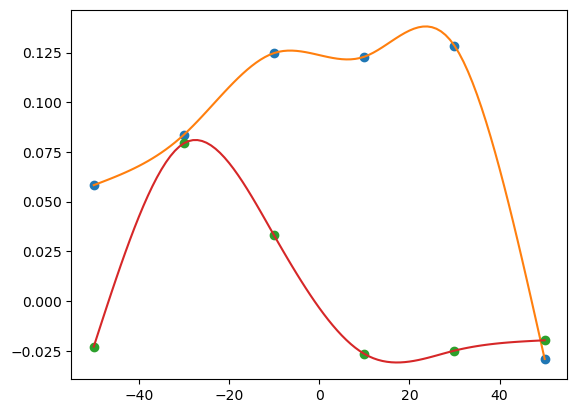

In [102]:
from scipy.interpolate import CubicSpline

ts              = np.linspace(-100/2, 100/2, 101)
pulse_func      = qt.interpolate.Cubic_Spline(ts[0], ts[-1], mean_I[-1].astype('float64'))
pulse_conj_func = qt.interpolate.Cubic_Spline(ts[0], ts[-1], mean_Q[-1].astype('float64'))

plt.plot(np.linspace(ts[0], ts[-1], 6), mean_I[-1], 'o')
plt.plot(ts, pulse_func(ts), '-')
plt.plot(np.linspace(ts[0], ts[-1], 6), mean_Q[-1], 'o')
plt.plot(ts, pulse_conj_func(ts), '-')
plt.show()

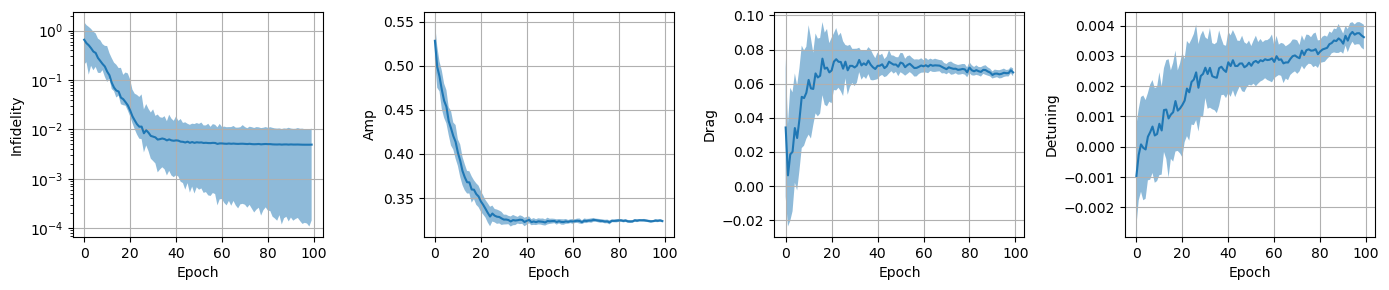

In [10]:
ts = np.arange(mean_I.shape[-1])

fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].plot(epochs, mean_infidelity)
ax[0].fill_between(epochs, mean_infidelity-min_infidelity, mean_infidelity+max_infidelity, alpha = 0.5)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Infidelity')
ax[0].set_yscale('log')
ax[0].grid(True)

ax[1].plot(epochs, mean_I)
ax[1].fill_between(epochs, mean_I-stdev_I, mean_I+stdev_I, alpha = 0.5)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Amp')
ax[1].grid(True)

ax[2].plot(epochs, mean_Q)
ax[2].fill_between(epochs, mean_Q-stdev_Q, mean_Q+stdev_Q, alpha = 0.5)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Drag') 
ax[2].grid(True)

fig.tight_layout()
plt.show()

ValueError: 'y1' is not 1-dimensional

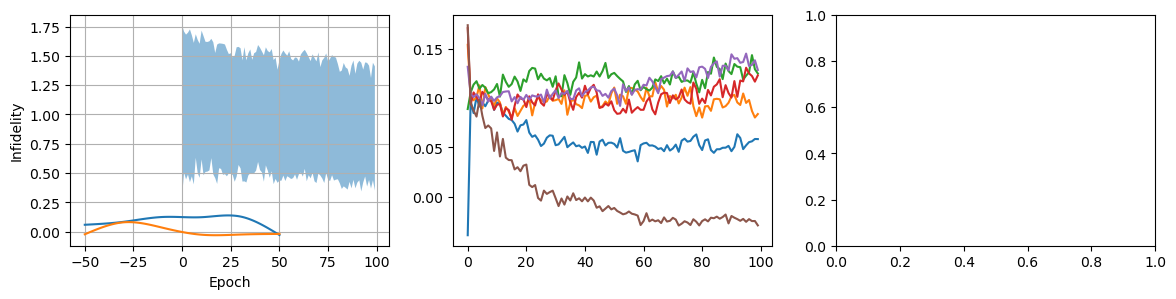

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].plot(ts, pulse_func(ts) )
ax[0].plot(ts, pulse_conj_func(ts) )
ax[0].fill_between(epochs, mean_infidelity-min_infidelity, mean_infidelity+max_infidelity, alpha = 0.5)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Infidelity')
# ax[0].set_yscale('log')
ax[0].grid(True)

ax[1].plot(epochs, mean_I)
ax[1].fill_between(epochs, mean_I-stdev_I, mean_I+stdev_I, alpha = 0.5)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Amp')
ax[1].grid(True)

ax[2].plot(epochs, mean_Q)
ax[2].fill_between(epochs, mean_Q-stdev_Q, mean_Q+stdev_Q, alpha = 0.5)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Drag') 
ax[2].grid(True)

fig.tight_layout()
plt.show()